In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot
from matplotlib import cm
from datetime import datetime
from pyproj import Transformer
from scipy.ndimage import convolve
# import holoviews as hv
# from holoviews import opts

# hv.extension('bokeh', 'matplotlib')

In [2]:
%run -i ncbx_funcs.py

In [3]:
url_CSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/dorian_his.ncml'
url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
url_FSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/dorian_his.ncml'
url_FSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/dorian_his.ncml'
#url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
run = 'CSYV'
ds_CSYV = xr.open_dataset(url_CSYV)
ds_CSYV

<xarray.Dataset>
Dimensions:                 (tracer: 4, NST: 3, s_rho: 8, s_w: 9,
                             eta_rho: 1057, xi_rho: 1317, eta_u: 1057,
                             xi_u: 1316, eta_v: 1056, xi_v: 1317,
                             eta_psi: 1056, xi_psi: 1316, ocean_time: 37,
                             NVEG: 3, Nbed: 1)
Coordinates:
  * s_rho                   (s_rho) float64 -0.9375 -0.8125 ... -0.1875 -0.0625
  * s_w                     (s_w) float64 -1.0 -0.875 -0.75 ... -0.25 -0.125 0.0
    lon_rho                 (eta_rho, xi_rho) float64 ...
    lat_rho                 (eta_rho, xi_rho) float64 ...
    lon_u                   (eta_u, xi_u) float64 ...
    lat_u                   (eta_u, xi_u) float64 ...
    lon_v                   (eta_v, xi_v) float64 ...
    lat_v                   (eta_v, xi_v) float64 ...
    lon_psi                 (eta_psi, xi_psi) float64 ...
    lat_psi                 (eta_psi, xi_psi) float64 ...
  * ocean_time              (ocean_time) datetime64[ns] 2019-09-06T10:15:00.0...
Dimensions without coordinates: tracer, NST, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi, NVEG, Nbed
Data variables: (12/182)
    ntimes                  int32 ...
    ndtfast                 int32 ...
    dt                      float64 ...
    dtfast                  float64 ...
    dstart                  datetime64[ns] ...
    nHIS                    int32 ...
    ...                      ...
    Dwave                   (ocean_time, eta_rho, xi_rho) float32 ...
    Pwave_top               (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_fric             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_break            (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_wcap             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_roller           (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/33)
    file:                      ./Output/Dorian_NCB_his_00019.nc
    format:                    netCDF-3 64bit offset file
    Conventions:               CF-1.4, SGRID-0.3
    type:                      ROMS/TOMS history file
    title:                     Hurricane Dorian North Core Banks
    var_info:                  varinfo.dat
    ...                        ...
    tiling:                    015x012
    history:                   ROMS/TOMS, Version 3.9, Saturday - October 15,...
    ana_file:                  ROMS/Functionals/ana_btflux.h, ROMS/Functional...
    CPP_options:               COREBANKS, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX,...
    EXTRA_DIMENSION.N:         8
    EXTRA_DIMENSION.boundary:  4

In [4]:
t=ds_CSYV.ocean_time.load()
tstring = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M')
tstring

Index(['2019-09-06 10:15', '2019-09-06 10:30', '2019-09-06 10:45',
       '2019-09-06 11:00', '2019-09-06 11:15', '2019-09-06 11:30',
       '2019-09-06 11:45', '2019-09-06 12:00', '2019-09-06 12:15',
       '2019-09-06 12:30', '2019-09-06 12:45', '2019-09-06 13:00',
       '2019-09-06 13:14', '2019-09-06 13:29', '2019-09-06 13:44',
       '2019-09-06 13:59', '2019-09-06 14:14', '2019-09-06 14:29',
       '2019-09-06 14:45', '2019-09-06 15:00', '2019-09-06 15:15',
       '2019-09-06 15:30', '2019-09-06 15:45', '2019-09-06 16:00',
       '2019-09-06 16:15', '2019-09-06 16:30', '2019-09-06 16:45',
       '2019-09-06 17:00', '2019-09-06 17:15', '2019-09-06 17:30',
       '2019-09-06 17:45', '2019-09-06 18:00', '2019-09-06 18:15',
       '2019-09-06 18:30', '2019-09-06 18:45', '2019-09-06 19:00',
       '2019-09-06 19:15'],
      dtype='object')

In [5]:
# load lat/lon, convert to island coordinates
lon = np.squeeze( ds_CSYV.lon_rho.load().values )
lat = np.squeeze( ds_CSYV.lat_rho.load().values )

# Convert lat/lon to UTM zone 18N, and then to island coordinates
transformer = Transformer.from_crs( 'epsg:4326', 'epsg:26918',  ) # WGS84 to UTM18
utmx, utmy = transformer.transform( lat, lon )
xisl, yisl = UTM2Island(utmx, utmy, eoff=383520.0, noff=3860830.0, rot=42.0)
print('Shape of xisl, yisl: ', xisl.shape, yisl.shape)


Shape of xisl, yisl:  (1057, 1317) (1057, 1317)


In [6]:
bt = ds_CSYV.bed_thickness[0,:,:,:].load().values

In [7]:
# load initial and final bathymetry
# Minus sign converts from depth to elevation
bathi = -ds_CSYV.bath[1,:,:].load().values
bathf = -ds_CSYV.bath[-1,:,:].load().values
bdiff = bathf - bathi

# smooth bathy for making contour maps
# experimenting with size of kernal suggest 15 is ok
ik = 15
k = np.ones((ik, ik)) / (ik*ik)
bathis = convolve(bathi,k,mode='nearest')
bathfs = convolve(bathf,k,mode='nearest')

# area calculations
pm = ds_CSYV.pm[:,:].load().values
pn = ds_CSYV.pn[:,:].load().values
area = 1./pm * 1./pn
print('Shape of area: ', area.shape)

vdiff = bdiff * area
print(np.sum(area))
print(np.sum(bdiff))
print(np.sum(vdiff))
print('bdiff')
stat_summary(bdiff, iprint=True)
print('vdiff')
stat_summary(vdiff, iprint=True)

Shape of area:  (1057, 1317)
19821987.311535504
-70593.43
243145.0925447774
bdiff
  n, nnan, nvalid:  1057 0 1057
  mean, std, min, max   : -0.051 0.353 -4.542 1.478
  d5, d25, d50, d75, d95: -0.410 -0.023 0.001 0.018 0.196
vdiff
  n, nnan, nvalid:  1057 0 1057
  mean, std, min, max   : 0.175 1.929 -49.830 70.158
  d5, d25, d50, d75, d95: -1.315 -0.134 0.005 0.146 2.611


{'n': 1057,
 'nnan': 0,
 'nvalid': 1057,
 'mean': 0.1746645407266288,
 'std': 1.9289193419431026,
 'min': -49.83044298234731,
 'max': 70.15775635512807,
 'd5': -1.315193128668792,
 'd25': -0.1340415790105609,
 'd50': 0.0045960437262363195,
 'd75': 0.146177606007145,
 'd95': 2.6111112905774303}

In [45]:
# Use a central line for cross-shore distance
y = np.squeeze( yisl[:,550] )

# find the average shoreline location
mbathi = np.mean(bathi[:,100:1200], axis=1)
mbathf = np.mean(bathf[:,100:1200], axis=1)
ishorey = np.argwhere(mbathi>=0.)[0]
print(ishorey, y[ishorey])

# use this for the cross-shore location by adding the offset
offset = y[ishorey]
y = y-offset
yisl = yisl-offset
xisl = xisl-np.min(xisl[ishorey])
# make the alongshore coordinates
x = np.squeeze( xisl[ishorey] - np.min(xisl[ishorey]) )

[168] [0.]


Contour intervals:  [-6. -4. -2.  0.  2.]


/tmp/ipykernel_203426/3306530196.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m0 = ax0.pcolormesh(xisl,yisl, bathi,cmap='terrain',vmin=-2,vmax=5)
/tmp/ipykernel_203426/3306530196.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m1 = ax1.pcolormesh(xisl,yisl, bathfs,cmap='terrain',vmin=-2,vmax=5)


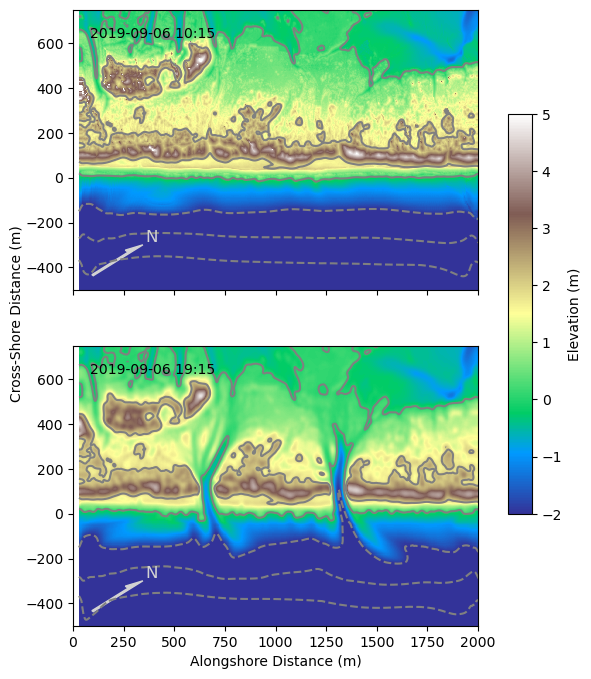

In [36]:
#### Before/after bathy
xs = 0
xe = 2000
ys = -500
ye = 750
levels = np.array( [-6, -4, -2, 0., 2.] )
print('Contour intervals: ', levels)
# north arrow calcs
# rot = 42
adx,ady = xycoord(.12, 90-42)

fig, (ax0, ax1 ) = plt.subplots(2,1,figsize=(6,8),sharex=True)
m0 = ax0.pcolormesh(xisl,yisl, bathi,cmap='terrain',vmin=-2,vmax=5)
m0c = ax0.contour(xisl,yisl, bathis,levels,colors='gray',vmin=-2,vmax=5)
# ax0.plot(650,750,'oy',label='Sound')
# ax0.plot(650,50,'or',label='Ocean')
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.text(0.35, 0.9, '{}'.format(tstring[0]), transform=ax0.transAxes, ha='right')
ax0.arrow( .05, .05,  adx, ady, shape = 'right', width=.01, color='lightgray', transform=ax0.transAxes )
ax0.text( .05+adx+.04, .05+ady+.04,'N',fontsize=12, color='lightgray', transform=ax0.transAxes )


m1 = ax1.pcolormesh(xisl,yisl, bathfs,cmap='terrain',vmin=-2,vmax=5)
m1c = ax1.contour(xisl,yisl, bathfs,levels,colors='gray',vmin=-2,vmax=5)
ax1.text(0.35, 0.9, '{}'.format(tstring[-1]), transform=ax1.transAxes, ha='right')
fig.text(0.02, 0.5, 'Cross-Shore Distance (m)', va='center', rotation='vertical')
ax1.set_xlabel('Alongshore Distance (m)')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.04, 0.5])
fig.colorbar(m1, cax=cbar_ax, label='Elevation (m)')
ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.arrow( .05, .05,  adx, ady, shape = 'right', width=.01, color='lightgray', transform=ax1.transAxes )
ax1.text( .05+adx+.04, .05+ady+.04,'N',fontsize=12, color='lightgray', transform=ax1.transAxes )

figname = run+'_int_final_bathy.png'
plt.savefig( figname, dpi=200, bbox_inches='tight') 

In [10]:
sed2i = np.squeeze( ds_CSYV.sandmass_02[0,:,:,:].load().values )
sed2f = np.squeeze( ds_CSYV.sandmass_02[-1,:,:,:].load().values )
sed3i = np.squeeze( ds_CSYV.sandmass_03[0,:,:,:].load().values )
sed3f = np.squeeze( ds_CSYV.sandmass_03[-1,:,:,:].load().values )
np.shape(sed2i)

(1057, 1317)

/tmp/ipykernel_203426/2653085203.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m0=ax0.pcolormesh(xisl, yisl, (sed2f-sed2i)+(sed3f-sed3i), cmap='seismic',vmin=-5000, vmax=5000)


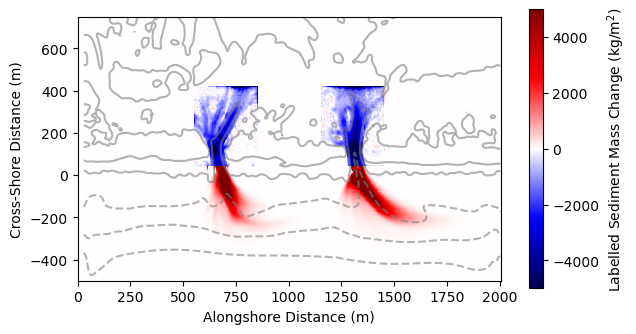

In [11]:
xs = 0
xe = 2000
ys = -500
ye = 750
levels = np.array( [-6, -4, -2, 0., 2.] )

fig, (ax0) = plt.subplots(1,1,figsize=(6,8),sharex=True)
m0=ax0.pcolormesh(xisl, yisl, (sed2f-sed2i)+(sed3f-sed3i), cmap='seismic',vmin=-5000, vmax=5000)
ax0.contour(xisl, yisl, bathfs, levels, colors='gray', alpha=.6)
#ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.set_aspect('equal')
ax0.set_ylabel('Cross-Shore Distance (m)')
ax0.set_xlabel('Alongshore Distance (m)')
plt.colorbar(m0,fraction=0.03, pad=0.06, label = 'Labelled Sediment Mass Change (kg/m$^2$)')
figname = run+'_labelled_sed_mass_diff.png'
plt.savefig( figname, dpi=200, bbox_inches='tight') 

i0, y[i0]: [168] [0.]
(1057,)


(-500.0, 500.0)

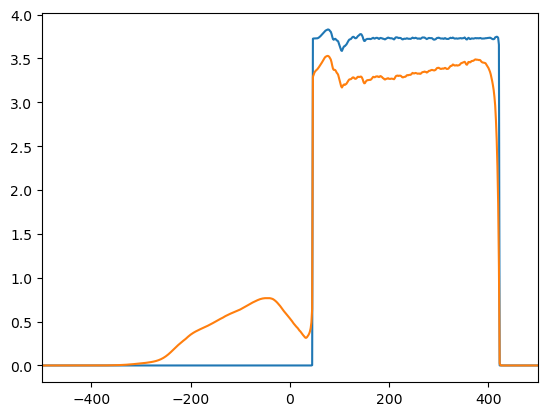

In [12]:
i0 = np.argwhere(y>=0.)[0]
print('i0, y[i0]:',i0, y[i0])
dy = np.diff(y)
dy = np.append( dy, dy[-1] )

voli = np.sum( (sed2i + sed3i), axis=1 )
volf = np.sum( (sed2f + sed3f), axis=1 )

delvol = volf-voli
print(np.shape(delvol))
plt.plot(y, voli/1.e6 )
plt.plot(y, volf/1.e6 )
#plt.plot(y, delvol/1.e6 )
#plt.plot(y, dy)
plt.xlim(-500, 500)

(-500.0, 0.0)

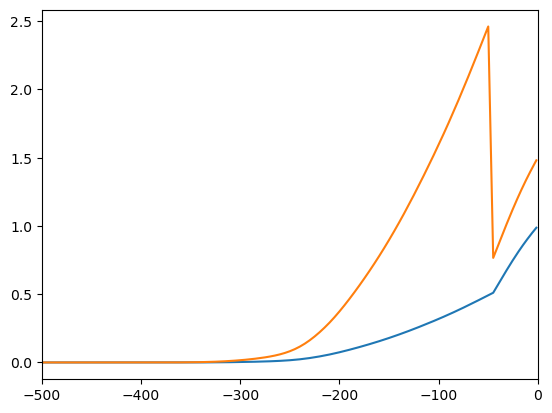

In [13]:
plt.plot(y[0:168], np.cumsum(volf)[0:168]/np.cumsum(volf)[168] )
plt.plot(y[0:168], dy[0:168]*np.cumsum(volf)[0:168]/np.cumsum(volf)[168] )
plt.xlim( -500, 0 )

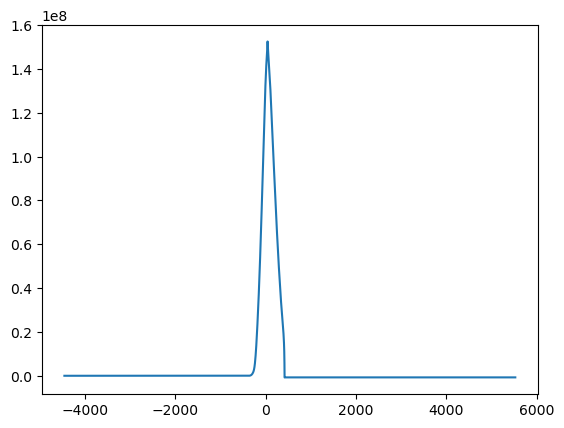

In [14]:
# this just confirms that the size classes are conserved
plt.plot(y, np.cumsum( delvol*dy ))

/tmp/ipykernel_203426/3238927798.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m0=ax0.pcolormesh(xisl, yisl, bdiff, cmap='seismic', vmin=-4, vmax=4)


Max., min., and mean bed diff.: 1.4781654 -4.5415716 -0.05071116


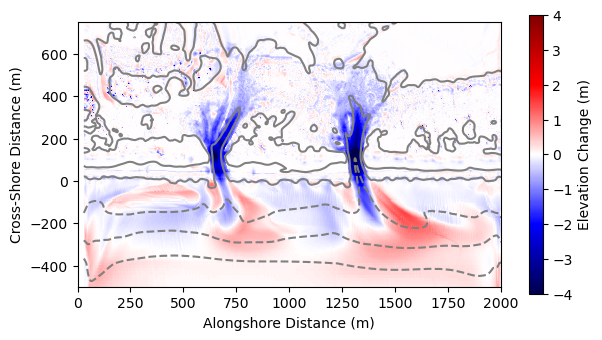

In [30]:
xs = 0
xe = 2000
ys = -500
ye = 750
levels = np.array( [-6, -4, -2, 0., 2.] )
fig, (ax0) = plt.subplots(1,1,figsize=(6,8),sharex=True)
m0=ax0.pcolormesh(xisl, yisl, bdiff, cmap='seismic', vmin=-4, vmax=4)
ax0.contour(xisl, yisl, bathfs, levels, colors='gray')
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.set_aspect('equal')
ax0.set_ylabel('Cross-Shore Distance (m)')
ax0.set_xlabel('Alongshore Distance (m)')
plt.colorbar(m0,fraction=0.03, pad=0.06, label='Elevation Change (m)')
figname = run+'_elevation_change.png'
plt.savefig( figname, dpi=200, bbox_inches='tight') 
print('Max., min., and mean bed diff.:', np.max(bdiff),np.min(bdiff),np.mean(bdiff))

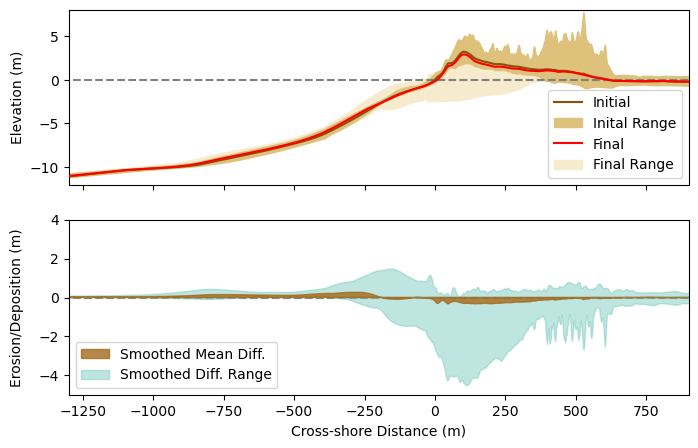

In [16]:
cmap = plt.get_cmap('BrBG')

ys = -1300
ye = 900

bdprof = running_mean( np.mean(bdiff[:,100:1200], axis=1), 5 )
bdprofmin = running_mean( np.min(bdiff[:,100:1200], axis=1), 5 )
bdprofmax = running_mean( np.max(bdiff[:,100:1200], axis=1), 5 )

bathyi_max = running_mean( np.max(bathi[:,100:1200], axis=1), 5 )
bathyi_min = running_mean( np.min(bathi[:,100:1200], axis=1), 5 )
bathyf_max = running_mean( np.max(bathf[:,100:1200], axis=1), 5 )
bathyf_min = running_mean( np.min(bathf[:,100:1200], axis=1), 5 )

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8,5),sharex=True)
ax0.plot(y, np.zeros_like(y),'--',c='gray')
ax0.plot(y, np.mean(bathi[:,100:1200], axis=1), c = cmap(.1),label='Initial', zorder=3)
ax0.fill_between(y, bathyi_max, bathyi_min, color = cmap(.3), label='Inital Range', zorder=1)
ax0.plot(y, np.mean(bathf[:,100:1200], axis=1), '-r',label='Final', zorder=3 )
ax0.fill_between(y, bathyf_max, bathyf_min, color = cmap(.42), label='Final Range', zorder=0)
# ax0.plot(y, bathy_max, '-k',label='Max')
# ax0.plot(y, bathy_min, '-k',label='Min')
ax0.legend()
ax0.set_ylabel('Elevation (m)')


ax0.set_xlim([ys, ye])
ax0.set_ylim([-12, 8])

ax1.plot(y,np.zeros_like(y),'--',c='gray',zorder=0)
ax1.fill_between(y,bdprof,0,label='Smoothed Mean Diff.',color=cmap(.15),alpha=.8,zorder=1)
ax1.fill_between(y,bdprofmin,0,label='Smoothed Diff. Range',color=cmap(.7),alpha=.5, zorder=0)
ax1.fill_between(y,bdprofmax,0, color=cmap(.7),alpha=.5, zorder=0)
ax1.set_xlim([ys, ye])
ax1.set_ylim([-5, 4])
ax1.set_xlabel('Cross-shore Distance (m)')
plt.legend(loc='lower left')
ax1.set_ylabel('Erosion/Deposition (m)')
#fig.text(0.04, 0.5, 'Elevation (m)', va='center', rotation='vertical')
fig.align_labels()
figname = run+'erosion_deposition_cross_section.png'
plt.savefig( figname, dpi=200, bbox_inches='tight')

176.85791535842907
net positive at : -190.00031873537495
y50, z50:  [-735.00122846] [-9.013431]
y25, z25:  [-1562.72557507] [-11.827576]
y5, z5:  [-3855.70476335] [-15.355657]


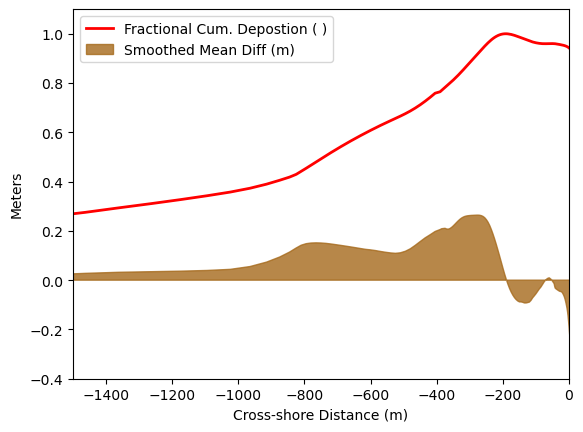

In [17]:
dy = np.diff(y)
dy = np.append( dy, dy[-1] )
cumdep = np.cumsum( bdprof*dy )
cumdepf = np.cumsum( np.flip(bdprof*dy) )

imax = np.argmax( cumdep )
cummax = cumdep[imax]
print(cummax)
print('net positive at :',y[imax] )

i50 = np.argwhere( cumdep/cummax >= 0.5 )[0]
print( 'y50, z50: ',y[i50], mbathi[i50] )
i25 = np.argwhere( cumdep/cummax >= 0.25 )[0]
print( 'y25, z25: ',y[i25], mbathi[i25] )
i5 = np.argwhere( cumdep/cummax >= 0.05 )[0]
print( 'y5, z5: ',y[i5], mbathi[i5] )

plt.plot(y, cumdep/cummax, linewidth=2, c='red', label='Fractional Cum. Depostion ( )')
plt.fill_between(y, bdprof, 0, color=cmap(.15),alpha=.8,zorder=1, label='Smoothed Mean Diff (m)')
plt.legend( loc = 'upper left')
plt.ylim( -.4, 1.1 )
plt.xlim( -1500, 0 )
plt.xlabel('Cross-shore Distance (m)')
plt.ylabel('Meters')
figname = run+'cumulative_cross_section.png'
plt.savefig( figname, dpi=200, bbox_inches='tight')

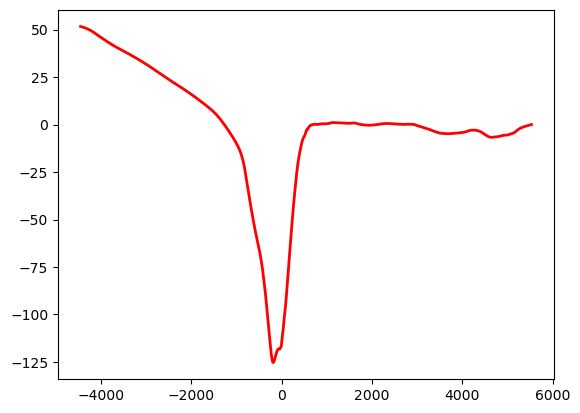

In [18]:
plt.plot(np.flip(y), cumdepf, linewidth=2, c='red', label='Fractional Cum. Depostion ( )')


#### Time-series of water elevations and difference

Sound zmax: 2.7950313091278076 at 2019-09-06T12:45:00.075094016
Diff max: 2.8085360527038574 at 2019-09-06T13:00:00.078527488
izsmax =  10 izdmax =  11


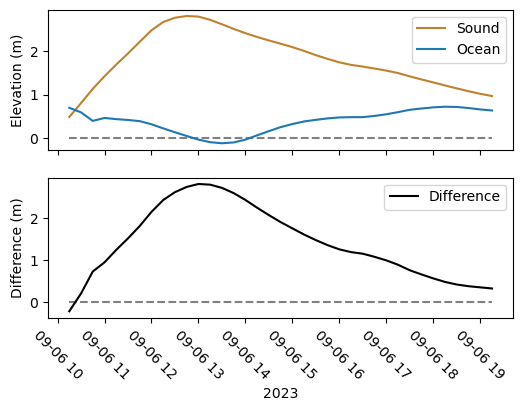

In [134]:
ys, xs = 750,650
yo, xo = 50, 650
zs = ds_CSYV.zeta[:,ys,xs].load()
zo = ds_CSYV.zeta[:,yo,xo].load()

izsmax = np.argmax(zs.values)
tzsmax = t.values[izsmax]
zsmax = zs.values[izsmax]
print('Sound zmax: {} at {}'.format(zsmax, tzsmax) )

zdiff = zs.values - zo.values
izdmax = np.argmax(zdiff)
tdmax = t.values[izdmax]
zdmax = zdiff[izdmax]
print('Diff max: {} at {}'.format(zdmax, tdmax) )
print('izsmax = ', izsmax, 'izdmax = ', izdmax) 

fig, (ax0, ax1 ) = plt.subplots(2,1,figsize=(6,4),sharex=True)
ax0.plot(t,np.zeros_like(zo),'--',c='gray')
ax0.plot(t,zs,c=cmap(.2),label='Sound')
ax0.plot(t,zo,c='tab:blue',label='Ocean')

ax0.set_ylabel('Elevation (m)')
ax0.legend()

ax1.plot(t,np.zeros_like(zo),'--',c='gray')
ax1.plot(t,zs-zo,c='k',label='Difference')
ax1.legend()
ax1.set_ylabel('Difference (m)')
plt.xticks(rotation=-45, ha='center')
plt.xlabel('2023')
figname = 'all_runs_water_level_ts.png'
plt.savefig( figname, dpi=200, bbox_inches='tight')

#### Location map for alongshore profiles and alongshore profiles.

/tmp/ipykernel_203426/2896894421.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m1 = ax.pcolormesh(xisl,yisl, bathfs,cmap='terrain',vmin=-2,vmax=5, zorder=0)


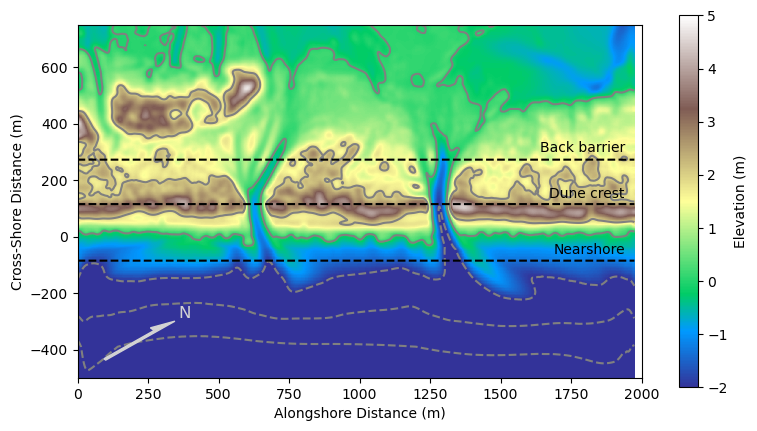

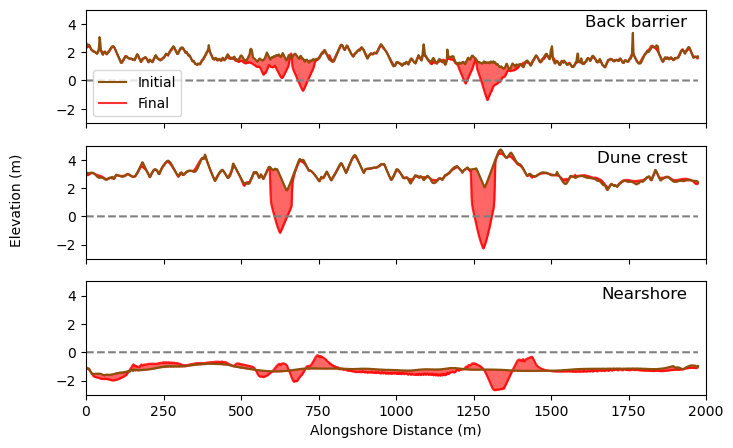

In [120]:
xsect_list = [130,245,350]
#fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,5), height_ratios=[3,1], constrained_layout=True)
fig, ax = plt.subplots(1,1, figsize=(8,6))

m1 = ax.pcolormesh(xisl,yisl, bathfs,cmap='terrain',vmin=-2,vmax=5, zorder=0)
m1c = ax.contour(xisl,yisl, bathfs,levels,colors='gray',vmin=-2,vmax=5, zorder=1)
# ax.text(0.35, 0.9, '{}'.format(tstring[-1]), transform=ax.transAxes, ha='right')
ax.text(0.97, 0.51, 'Dune crest', transform=ax.transAxes, ha='right')
ax.text(0.97, 0.64, 'Back barrier', transform=ax.transAxes, ha='right')
ax.text(0.97, 0.35, 'Nearshore', transform=ax.transAxes, ha='right')

ax.set_ylabel('Cross-Shore Distance (m)')
ax.set_aspect('equal')

#fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.25, 0.04, 0.5])
#fig.colorbar(m1, cax=cbar_ax, label='Elevation (m)')
fig.colorbar(m1, fraction=0.03, pad=0.06, label='Elevation (m)')

ax.plot(x, y[xsect_list[0]]*np.ones_like(x), '--k')
ax.plot(x, y[xsect_list[1]]*np.ones_like(x), '--k')
ax.plot(x, y[xsect_list[2]]*np.ones_like(x), '--k')

ax.set_xlim([xs, xe])
ax.set_ylim([ys, ye])
ax.arrow( .05, .05,  adx, ady, shape = 'right', width=.01, color='lightgray', transform=ax.transAxes, zorder=2 )
ax.text( .05+adx+.04, .05+ady+.04,'N',fontsize=12, color='lightgray', transform=ax.transAxes, zorder=2 )
ax.set_xlabel('Alongshore Distance (m)')
figname = run+'alongshore_sec_loc.png'
plt.savefig( figname, dpi=200, bbox_inches='tight')

# alongshore profiles before/after
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,5) )
ax[0].plot(x, np.zeros_like(x),'--',c='gray')
ax[0].plot(x, bathi[xsect_list[2],:],label='Initial',c = cmap(.1),zorder=1)
ax[0].plot(x, bathf[xsect_list[2],:],label='Final', c='r', zorder=0, alpha=.8)
ax[0].fill_between(x, bathf[xsect_list[2],:], bathi[xsect_list[2],:], color='r', zorder=0, alpha=.6)

ax[0].set_ylim( [-3, 5] )
ax[0].set_xlim( [xs, xe] )
ax[0].legend( loc = 'lower left')
ax[0].text( .97, .85,'Back barrier',fontsize=12, ha='right', color='k', transform=ax[0].transAxes )

ax[1].plot(x, np.zeros_like(x),'--',c='gray')
ax[1].plot(x, bathi[xsect_list[1],:],label='Initial',c = cmap(.1),zorder=1)
ax[1].plot(x, bathf[xsect_list[1],:],label='Final', c='r', zorder=0, alpha=.8)
ax[1].fill_between(x, bathf[xsect_list[1],:], bathi[xsect_list[1],:],label='Final', color='r', zorder=0, alpha=.6)
ax[1].set_ylim( [-3, 5] )
ax[1].text( .97, .85,'Dune crest',fontsize=12, ha='right', color='k', transform=ax[1].transAxes )


ax[2].plot(x, np.zeros_like(x),'--',c='gray')
ax[2].plot(x, bathi[xsect_list[0],:],label='Initial', c = cmap(.1),zorder=1)
ax[2].plot(x, bathf[xsect_list[0],:],label='Final', c='r', zorder=0, alpha=.8)
ax[2].fill_between(x, bathf[xsect_list[0],:], bathi[xsect_list[0],:],label='Final', color='r', zorder=0, alpha=.6)

ax[2].set_ylim( [-3, 5] )
ax[2].text( .97, .85,'Nearshore',fontsize=12, ha='right', color='k', transform=ax[2].transAxes )


# ax[1].legend()
ax[2].set_xlabel('Alongshore Distance (m)')
fig.text(0.03, 0.5, 'Elevation (m)', va='center', rotation='vertical')
figname = run+'alongshore_sections.png'
plt.savefig( figname, dpi=200, bbox_inches='tight')

#### Cross-barrier profile showing location of alongshore profiles

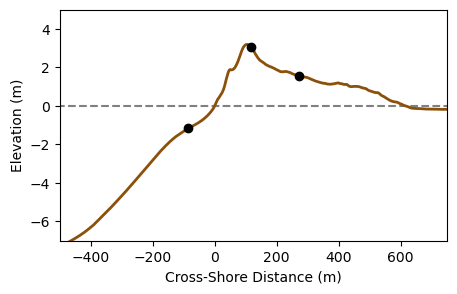

In [124]:
fig = plt.figure( figsize=(5,3) )
mbathi = np.mean(bathi[:,100:1200], axis=1)
plt.plot(y,np.zeros_like(mbathi),'--',c='gray')
plt.plot(y,mbathi,c = cmap(.1), linewidth=2)
plt.plot(y[xsect_list[2]],mbathi[xsect_list[2]],'ok')
plt.plot(y[xsect_list[1]],mbathi[xsect_list[1]],'ok')
plt.plot(y[xsect_list[0]],mbathi[xsect_list[0]],'ok')

plt.xlim( ys, ye )
plt.ylim( [-7, 5] )
plt.ylabel('Elevation (m)')
plt.xlabel('Cross-Shore Distance (m)')
figname = run+'profile_sec_loc.png'
plt.savefig( figname, dpi=200, bbox_inches='tight')